## Bacteria Segmentation using UNET in Pytorch

In this notebook we are going to implement UNET architecture for Bacteria segmentation. The dataset was collected from kaggle and has been loaded in my local disc with the images stored in the `images` folder and masks in the `masks` folder.

**Disclaimer :** I am going to import all the necessary packages in the first cell so don't be overwhelmed by it.

In [1]:
## Importing the necessary datasets ##

import os

from PIL import Image
import torch
import torch.nn as nn
import torchvision
from torchvision.transforms import transforms
from torchvision.transforms.functional import resize 
from torch.utils.data import DataLoader , Dataset
from torchvision.utils import make_grid , save_image

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

With all the packages imported its time to get our hands dirty with the project.

It is always better to visualize the dataset to get a taste of what it is.

We are going to utilize PIL and matplotlib for this purpose.

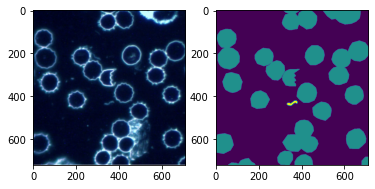

In [2]:
## Visualizing image and mask ##

## Opening the image and mask images ##
img = Image.open('images/001.png').convert('RGB')
img_mask = Image.open('masks/001.png').convert('L') ## To extract only the content ##

## Converting them into arrays ##
img_arr = np.array(img) / 255.
mask_arr = np.array(img_mask) / 255.

## Plotting the image ##
plt.subplot(1 , 2 , 1)
plt.imshow(img_arr)

## Plotting the mask ##
plt.subplot(1 , 2 , 2)
plt.imshow(mask_arr)

plt.show()

So we can sense the way we need to repurpose our dataset to feed data to our model, which is the main building block of this project.

In the subsequent cells we are going to implement the dataset for our project and we need to do the following things.

- [ ] Create a dataset class which inherits from the pytorch dataset module.
- [ ] Initialize the constructor for the class which takes the image and mask path.
- [ ] Override the `__getitem__`method which outputs a set of data and label by taking in an index.
- [ ] Override the `__len__` method to determine the length of the dataset.

In [3]:
## Creating the custom dataset ##

class BacteriaDataset(Dataset):
    
    def __init__(self , img_path , mask_path):
        self.base_path = 'D://DL_Using_Pytorch//10.UNET_Bacteria_Segmentation'
        self.img_path = img_path
        self.mask_path = mask_path
        self.img_list = os.listdir(os.path.join(self.base_path , img_path))
        self.mask_list = os.listdir(os.path.join(self.base_path , mask_path))
        self.dataset_len = len(self.img_list)
        
    def __getitem__(self , idx):
        cycle_idx = idx % self.dataset_len
        
        img = Image.open(os.path.join(os.path.join(self.base_path , self.img_path) , self.img_list[cycle_idx])).convert('RGB')
        img_mask = Image.open(os.path.join(os.path.join(self.base_path , self.mask_path) , self.mask_list[cycle_idx])).convert('L') 
        
        aug = transforms.Compose([
            transforms.Resize((64 , 64)),
            transforms.ToTensor()
        ])
        
        img_tensor = aug(img)
        mask_tensor = aug(img_mask)
        
        
        return img_tensor , mask_tensor
    
    def __len__(self):
        return self.dataset_len

In [4]:
## Instantiating the dataset ##

bacteria_data = BacteriaDataset('images' , 'masks')

print('The length of the dataset is :' , len(bacteria_data))

The length of the dataset is : 366


We can see that the code ran without error.

But it is of the best interest to visualize an example for error checking. So lets do that.

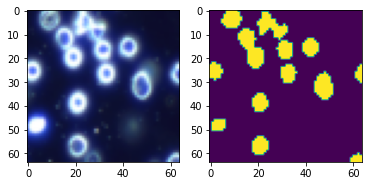

In [5]:
## Visualizing a data point ##

np.random.seed(47)

rand_idx = int(np.random.randint(0 , len(bacteria_data) , size = 1))

img , mask = bacteria_data[rand_idx]

#img = img.squeeze(0)
#mask = mask.squeeze(0)

## Plotting the image ##
plt.subplot(1 , 2 , 1)
plt.imshow(img.permute(1 , 2 , 0))

## Plotting the mask ##
plt.subplot(1 , 2 , 2)
plt.imshow(mask.permute(1 , 2 , 0))

plt.show()

Now with the dataset out of the way, it would be really unreasonable to put the entire dataset to the model. 

Hence, comes the requirements of a DataLoader. It takes in the dataset as input and spits out batches of data for updation of weight via mini-batches.

In [6]:
## Instantiating DataLoader ##

bacteria_dl = DataLoader(bacteria_data , batch_size = 16 , shuffle = True)

print('The length of the dataloader is:' , len(bacteria_dl))

The length of the dataloader is: 23


Its always better to visualize a set of the dataset to get better insight.

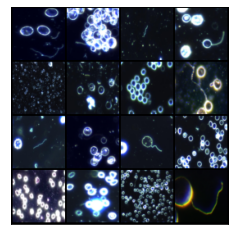

In [7]:
## Displaying images ##

for img , mask in bacteria_dl:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(img  , 4).permute(1 , 2 , 0))
    #plt.imshow(make_grid(mask , 4).permute(1 , 2 , 0))
    plt.show()
    break

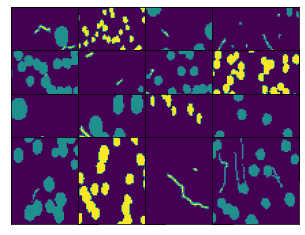

In [8]:
## Displaying mask ##

for img , mask in bacteria_dl:
    for i in range(len(mask)):
        plt.subplot(4 , 4 , i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mask[i].permute(1 , 2 , 0))
    plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
    plt.show()
    break

Now we have created the dataloader.

But, it is not enough! Why not? Well the dataloader utilizes cpu for its working. But that is quite inefficient. We need to push it to GPU. Hence we need to write some code which would do that for us and make the process much more efficient.

In [9]:
## GPU transfer utility functions ##

def check_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    return torch.device('cpu')

def transfer_data(data , device):
    if isinstance(data , (list , tuple)):
        return [transfer_data(each_data , device) for each_data in data]
    return data.to(device)

Now we have sorted the utility functions.

Now next what we do is create our custom dataloader which utilizes GPU.

In [10]:
## GPU Dataloader ##

class GPUDataLoader():
    
    def __init__(self , dl , device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for batch in self.dl:
            yield transfer_data(batch , self.device)
    
    def __len__(self):
        return len(self.dl)

In [11]:
## Instantiating our dataloader ##

device = check_device()

dl_bacteria = GPUDataLoader(bacteria_dl , device)

Okay! The dataloader is instantiated.

Lets check some test cases such that we can be assured of the requirements.

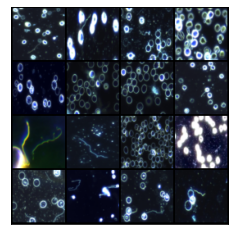

In [12]:
## Displaying images ##

for img , mask in dl_bacteria:
    fig , ax = plt.subplots(figsize = (4 , 4))
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(make_grid(img.to('cpu')  , 4).permute(1 , 2 , 0))
    #plt.imshow(make_grid(mask , 4).permute(1 , 2 , 0))
    plt.show()
    break

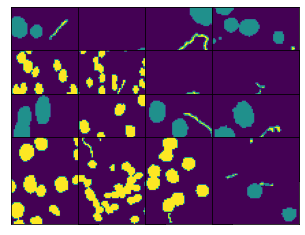

In [13]:
## Displaying mask ##

for img , mask in dl_bacteria:
    for i in range(len(mask)):
        plt.subplot(4 , 4 , i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(mask.to('cpu')[i].permute(1 , 2 , 0))
    plt.subplots_adjust(wspace=-0.5, hspace=-0.5)
    plt.show()
    break

Okay. So our dataloader is working excellently.

So, now we are all set for the final part.

Our main UNET structure.

![Unet Architecture](unet.png)

The main architecture of UNET is given above-- from the original paper.

What we are going to do is improvise a bit and carry on.

Our starting dimension is 64,64,3. 

So lets model our UNET.

In [14]:
## Defining Unet Architecture ##

class UnetConv(nn.Module):
    
    def __init__(self , in_dim , out_dim , kernel_size = 3 , padding = 1 , stride = 1):
        
        super().__init__()
        
        self.conv_block = nn.Sequential(nn.Conv2d(in_channels = in_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True),
                            nn.Conv2d(in_channels = out_dim , out_channels = out_dim , kernel_size = kernel_size ,
                                       padding = padding , stride = stride , bias = False),
                            nn.BatchNorm2d(num_features = out_dim) ,
                            nn.ReLU(inplace = True))
        
    def forward(self , inp):
        return self.conv_block(inp)

class BacteriaUNET(nn.Module):
    
    def __init__(self , in_dim = 3 , out_dim = 1 , filters = [64 , 128 , 256 , 512]):
        super().__init__()
        self.filters = filters
        self.out_dim = out_dim
        self.max_pool = nn.MaxPool2d(kernel_size = 2 , stride = 2)
        
        self.down_block = nn.ModuleList([])
        self.up_block = nn.ModuleList([])
        
        for each_filter in self.filters:
            self.down_block.append(UnetConv(in_dim = in_dim , out_dim = each_filter))
            in_dim = each_filter
            
        for each_filter in reversed(self.filters):
            self.up_block.append(nn.ConvTranspose2d(in_channels = each_filter * 2 , out_channels = each_filter , 
                                                    kernel_size = 2 , stride= 2))
            self.up_block.append(UnetConv(in_dim = each_filter * 2 , out_dim = each_filter))
            
        
        self.bridge_block = UnetConv(in_dim = self.filters[-1] , 
                                      out_dim = self.filters[-1] * 2)
        
        self.final_layer = nn.Conv2d(in_channels = self.filters[0] , out_channels = self.out_dim,
                                     kernel_size = 1)
        
        
    def forward(self , x):
        
        down_conv_out = []
        
        for layer in self.down_block:
            x = layer(x) 
            down_conv_out.append(x)
            x = self.max_pool(x)
            
        x = self.bridge_block(x)
        
        down_conv_out = down_conv_out[::-1]
            
        for layer_num in range(0 , len(self.up_block) , 2):
            
            x = self.up_block[layer_num](x)
            skip_conn = down_conv_out[layer_num // 2]
            
            if x.shape != skip_conn.shape:
                
                x = resize(x , size = skip_conn.shape[2:])
                
            
            x = torch.cat((x , skip_conn) , dim = 1)
            
            x = self.up_block[layer_num + 1](x)
            
        x = self.final_layer(x)
        
        return x

In [15]:
## Instantiating our model ##

model = BacteriaUNET()

model = model.to(device)

Now our model is done and dusted.

Lets initialize our loss function and optimizer.

In [16]:
## Initializing loss function and optimizer ##

loss_fn = nn.BCEWithLogitsLoss()

optim = torch.optim.Adam(params = model.parameters() , lr = 3e-4)

We are going to now move on to the training loop. 

Epoch : 1 / 100 --> Loss : 0.353
Epoch : 2 / 100 --> Loss : 0.256
Epoch : 3 / 100 --> Loss : 0.227
Epoch : 4 / 100 --> Loss : 0.199


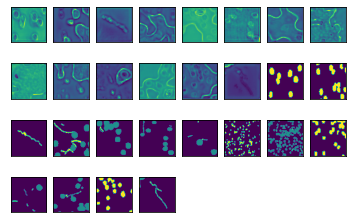

Epoch : 5 / 100 --> Loss : 0.174
Epoch : 6 / 100 --> Loss : 0.153
Epoch : 7 / 100 --> Loss : 0.134
Epoch : 8 / 100 --> Loss : 0.119
Epoch : 9 / 100 --> Loss : 0.107


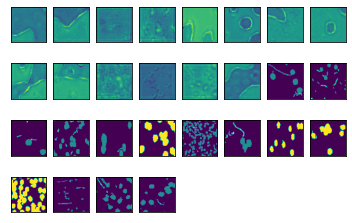

Epoch : 10 / 100 --> Loss : 0.095
Epoch : 11 / 100 --> Loss : 0.086
Epoch : 12 / 100 --> Loss : 0.078
Epoch : 13 / 100 --> Loss : 0.071
Epoch : 14 / 100 --> Loss : 0.065


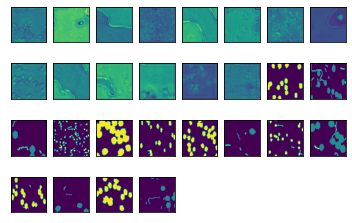

Epoch : 15 / 100 --> Loss : 0.059
Epoch : 16 / 100 --> Loss : 0.055
Epoch : 17 / 100 --> Loss : 0.050
Epoch : 18 / 100 --> Loss : 0.047
Epoch : 19 / 100 --> Loss : 0.044


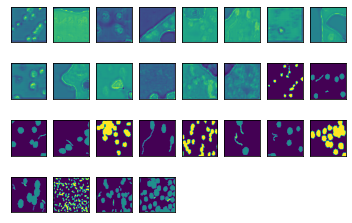

Epoch : 20 / 100 --> Loss : 0.040
Epoch : 21 / 100 --> Loss : 0.039
Epoch : 22 / 100 --> Loss : 0.035
Epoch : 23 / 100 --> Loss : 0.033
Epoch : 24 / 100 --> Loss : 0.031


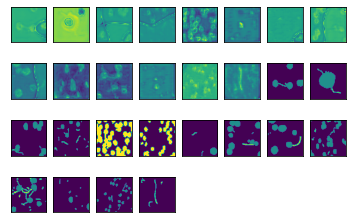

Epoch : 25 / 100 --> Loss : 0.029
Epoch : 26 / 100 --> Loss : 0.028
Epoch : 27 / 100 --> Loss : 0.026
Epoch : 28 / 100 --> Loss : 0.024
Epoch : 29 / 100 --> Loss : 0.022


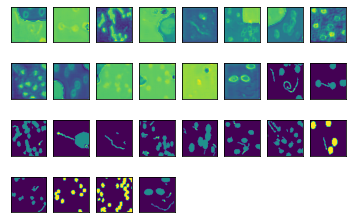

Epoch : 30 / 100 --> Loss : 0.022
Epoch : 31 / 100 --> Loss : 0.021
Epoch : 32 / 100 --> Loss : 0.020
Epoch : 33 / 100 --> Loss : 0.020
Epoch : 34 / 100 --> Loss : 0.018


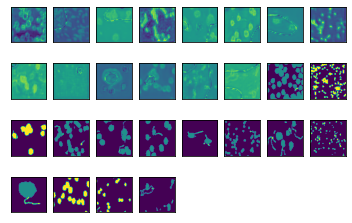

Epoch : 35 / 100 --> Loss : 0.018
Epoch : 36 / 100 --> Loss : 0.017
Epoch : 37 / 100 --> Loss : 0.015
Epoch : 38 / 100 --> Loss : 0.015
Epoch : 39 / 100 --> Loss : 0.015


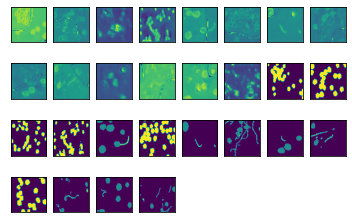

Epoch : 40 / 100 --> Loss : 0.014
Epoch : 41 / 100 --> Loss : 0.015
Epoch : 42 / 100 --> Loss : 0.014
Epoch : 43 / 100 --> Loss : 0.013
Epoch : 44 / 100 --> Loss : 0.012


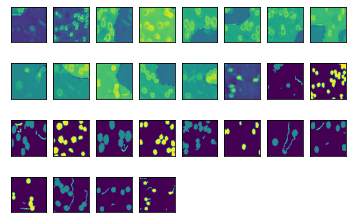

Epoch : 45 / 100 --> Loss : 0.012
Epoch : 46 / 100 --> Loss : 0.013
Epoch : 47 / 100 --> Loss : 0.011
Epoch : 48 / 100 --> Loss : 0.011
Epoch : 49 / 100 --> Loss : 0.011


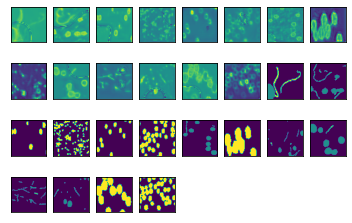

Epoch : 50 / 100 --> Loss : 0.011
Epoch : 51 / 100 --> Loss : 0.011
Epoch : 52 / 100 --> Loss : 0.010
Epoch : 53 / 100 --> Loss : 0.010
Epoch : 54 / 100 --> Loss : 0.010


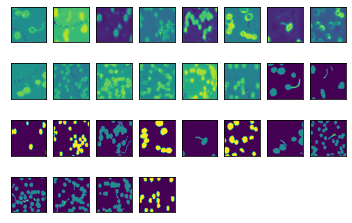

Epoch : 55 / 100 --> Loss : 0.010
Epoch : 56 / 100 --> Loss : 0.008
Epoch : 57 / 100 --> Loss : 0.009
Epoch : 58 / 100 --> Loss : 0.009
Epoch : 59 / 100 --> Loss : 0.009


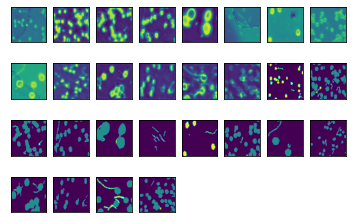

Epoch : 60 / 100 --> Loss : 0.009
Epoch : 61 / 100 --> Loss : 0.009
Epoch : 62 / 100 --> Loss : 0.008
Epoch : 63 / 100 --> Loss : 0.008
Epoch : 64 / 100 --> Loss : 0.008


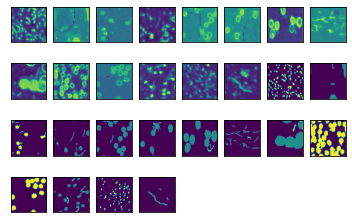

Epoch : 65 / 100 --> Loss : 0.007
Epoch : 66 / 100 --> Loss : 0.007
Epoch : 67 / 100 --> Loss : 0.008
Epoch : 68 / 100 --> Loss : 0.008
Epoch : 69 / 100 --> Loss : 0.007


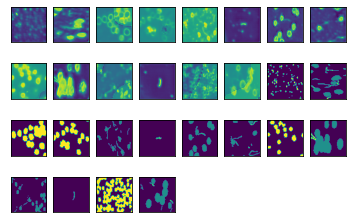

Epoch : 70 / 100 --> Loss : 0.008
Epoch : 71 / 100 --> Loss : 0.007
Epoch : 72 / 100 --> Loss : 0.007
Epoch : 73 / 100 --> Loss : 0.007
Epoch : 74 / 100 --> Loss : 0.006


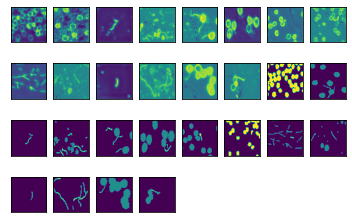

Epoch : 75 / 100 --> Loss : 0.006
Epoch : 76 / 100 --> Loss : 0.008
Epoch : 77 / 100 --> Loss : 0.007
Epoch : 78 / 100 --> Loss : 0.006
Epoch : 79 / 100 --> Loss : 0.007


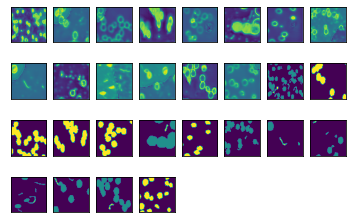

Epoch : 80 / 100 --> Loss : 0.007
Epoch : 81 / 100 --> Loss : 0.006
Epoch : 82 / 100 --> Loss : 0.007
Epoch : 83 / 100 --> Loss : 0.007
Epoch : 84 / 100 --> Loss : 0.006


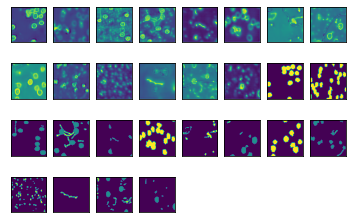

Epoch : 85 / 100 --> Loss : 0.005
Epoch : 86 / 100 --> Loss : 0.006
Epoch : 87 / 100 --> Loss : 0.006
Epoch : 88 / 100 --> Loss : 0.007
Epoch : 89 / 100 --> Loss : 0.006


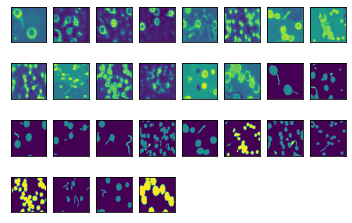

Epoch : 90 / 100 --> Loss : 0.006
Epoch : 91 / 100 --> Loss : 0.005
Epoch : 92 / 100 --> Loss : 0.007
Epoch : 93 / 100 --> Loss : 0.006
Epoch : 94 / 100 --> Loss : 0.006


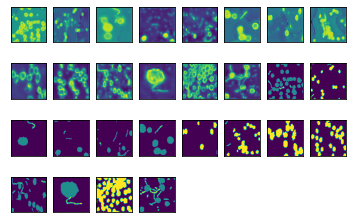

Epoch : 95 / 100 --> Loss : 0.006
Epoch : 96 / 100 --> Loss : 0.006
Epoch : 97 / 100 --> Loss : 0.005
Epoch : 98 / 100 --> Loss : 0.005
Epoch : 99 / 100 --> Loss : 0.006


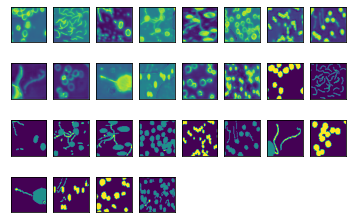

Epoch : 100 / 100 --> Loss : 0.007


In [17]:
## Training loop ##

num_epochs = 100

for epoch in range(num_epochs):
    
    for img , mask in dl_bacteria:
        
        model.train()
        
        pred = model(img)
        
        loss = loss_fn(pred , mask)
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
    
    model.eval()
    
    if (epoch + 1) % 5 == 0:
        for i in range(len(pred)):
            plt.subplot(4 , 8 , i+1)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(pred[i].detach().to('cpu').permute(1 , 2 , 0))
            plt.subplot(4 , 8 , i+15)
            plt.xticks([])
            plt.yticks([])
            plt.imshow(mask[i].to('cpu').permute(1 , 2 , 0))
        
        plt.show()
    
    print('Epoch : {} / {} --> Loss : {:.3f}'.format(epoch + 1 , num_epochs , loss.item()))